In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/SNLP/aalto-snlp-project-spring-2024"

/content/drive/.shortcut-targets-by-id/1B0EzOSjRZNGQDfkh7FcoUSO2itFQjxtV/aalto-snlp-project-spring-2024


In [1]:
import pandas as pd
df = pd.read_csv(f'train_2024.csv', quoting=3)
df.groupby('label').count()

/var/folders/86/h1q7vkt937n4jdt7nw_1mp040000gn/T/ipykernel_14128/305914732.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,id,text
label,,
0,62633,62633
1,36367,36367


In [6]:
62633/36367

1.7222481920422361

In [3]:
(62633 + 36367)/36367

2.722248192042236

In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import pandas as pd
import time
from sklearn.metrics import f1_score


In [4]:
if torch.cuda.is_available():
	print(f'Using GPU: {torch.cuda.get_device_name(0)}')
	device = torch.device("cuda")
elif torch.backends.mps.is_available():
	print('Using MPS')
	device = torch.device("mps")
else:
	print('Using CPU')
	device = torch.device("cpu")


Using GPU: Tesla T4


# Load Dataset

In [5]:
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import unicodedata
import re
import spacy
from tqdm import tqdm

SOS_token = 1
EOS_token = 2
CLS_token = 3
lemmatizer = spacy.load("en_core_web_sm")

class TranslationDataset(Dataset):
	def __init__(self, csv_path, dataset_type='train', vocab=None):
		df = pd.read_csv(csv_path, quoting=3)
		print(f'len df: {len(df)}')
		if dataset_type in ['train', 'val']:
			self.text, self.labels = zip(*[(text, label) for text, label in zip(df['text'], df['label'])])
		else:
			self.text = df['text'].tolist()
			self.labels = [0 for _ in range(len(self.text))]
		self.ids = df['id'].tolist()
		self.dataset_type = dataset_type
		self.tokenizer = get_tokenizer('basic_english')
		self._preprocess(vocab)

	def _preprocess(self, vocab):
		# preprocess text
		self.text = [self._preprocess_sentence(text) for text in tqdm(self.text)]

		if vocab is None:
			self.vocab = build_vocab_from_iterator(self._yield_tokens(), specials=["<UNK>"])
			self.vocab.set_default_index(self.vocab['<UNK>']) # Set the default index to <UNK> token, which mean
			self.vocab.insert_token('<SOS>', SOS_token)  # Insert <EOS> token with index 1
			self.vocab.insert_token('<EOS>', EOS_token)  # Insert <EOS> token with index 2
			self.vocab.insert_token('<CLS>', CLS_token)  # Insert <CLS> token with index 3
		else:
			self.vocab = vocab

		self.vocab_size = len(self.vocab)

	def _preprocess_sentence(self, sentence):
		sentence = normalizeString(sentence)
		sentence = self.tokenizer(sentence)
		sentence = lemmaString(sentence)
		return sentence

	def _yield_tokens(self):
		for text_sample in self.text:
			yield text_sample

	def __len__(self):
		return len(self.text)

	def __getitem__(self, idx):
		input_seq = text_to_indices(self.vocab, self.text[idx])
		label = self.labels[idx]
		return input_seq, label, self.ids[idx]

def unicodeToAscii(s):
	return ''.join(
		c for c in unicodedata.normalize('NFD', s)
		if unicodedata.category(c) != 'Mn'
	)

def normalizeString(s):
	s = unicodeToAscii(s.lower().strip())
	s = re.sub(r"([.!?])", r" \1", s)
	s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
	return s

def lemmaString(tokens):
	return [token.lemma_ for token in lemmatizer(' '.join(tokens))]

def text_to_indices(vocab, tokens):
	indices = [vocab[token] for token in tokens]
	# add EOS token at the end
	indices.append(EOS_token)
	return torch.tensor(indices, dtype=torch.long).view(-1)

def seq_to_tokens(seq, vocab):
    itos = vocab.get_itos()
    return [itos[idx] for idx in seq]

In [6]:
# trainset = TranslationDataset('train_2024.csv', dataset_type='train', vocab=None)
# valset = TranslationDataset('dev_2024.csv', dataset_type='val', vocab=trainset.vocab)
# testset = TranslationDataset('test_2024.csv', dataset_type='test', vocab=trainset.vocab)

In [7]:
# # save trainset, valset, testset
# torch.save(trainset, 'datasets/transformer/trainset.pth')
# torch.save(valset, 'datasets/transformer/valset.pth')
# torch.save(testset, 'datasets/transformer/testset.pth')

In [8]:
trainset = torch.load('datasets/transformer/trainset.pth')
valset = torch.load('datasets/transformer/valset.pth')
testset = torch.load('datasets/transformer/testset.pth')

print(trainset.vocab['<UNK>'])
print(trainset.vocab['<SOS>'])
print(trainset.vocab['<EOS>'])
print(trainset.vocab['<CLS>'])

0
1
2
3


# Custom DataLoader

In [9]:
PADDING_VALUE = 0

In [10]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
	"""Merges a list of samples to form a mini-batch.

	Args:
	list_of_samples is a list of tuples (src_seq, tgt_label, id):
		src_seq is of shape (src_seq_length,)
		tgt_label is of shape (1,)
		id is an int

	Returns:
	src_seqs of shape (max_src_seq_length, batch_size): Tensor of padded source sequences.
	src_mask of shape (max_src_seq_length, batch_size): Boolean tensor showing which elements of the src_seqs tensor should be ignored in computations.
	tgt_labels of shape (batch_size, 1): Tensor of labels for each sequence.
	"""
	# YOUR CODE HERE
	src_seqs = [s[0] for s in list_of_samples]
	src_seqs = pad_sequence(src_seqs, batch_first=False, padding_value=PADDING_VALUE, )

	tgt_labels = torch.LongTensor([s[1] for s in list_of_samples])

	# Add CLS token at the beginning of each src sequence
	cls_tensor = torch.full((1, src_seqs.shape[1]), CLS_token, dtype=torch.long)
	src_seqs = torch.cat((cls_tensor, src_seqs), dim=0)

	ids = [s[2] for s in list_of_samples]

	# Create mask (ALWAYS keep it at the end of the function)
	src_masks = (src_seqs == PADDING_VALUE)

	return src_seqs, src_masks, tgt_labels, ids


In [11]:
trainloader = DataLoader(dataset=trainset, batch_size=640, shuffle=False, collate_fn=collate, pin_memory=True)
valloader = DataLoader(dataset=valset, batch_size=32, shuffle=False, collate_fn=collate, pin_memory=True)
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=True)

In [12]:
# This cell tests collate()
def test_collate():
    pairs = [
        (torch.LongTensor([2, EOS_token]), 0, 0),
        (torch.LongTensor([6, 7, EOS_token]), 1, 1),
    ]
    src_seqs, src_mask, tgt_seqs, ids = collate(pairs)
    #src_seqs, src_mask, tgt_seqs = src_seqs[:, [1, 0]], src_mask[:, [1, 0]], tgt_seqs[:, [1, 0]]
    print('src_seqs:\n', src_seqs)
    print('src_mask:\n', src_mask)
    print('tgt_seqs:\n', tgt_seqs)
    expected_src_seqs = torch.tensor([
        [CLS_token, CLS_token],
        [2,         6],
        [EOS_token, 7],
        [0,         EOS_token]
    ])
    expected_src_mask = torch.tensor([
        [False, False],
        [False, False],
        [False, False],
        [ True, False]
    ])
    expected_tgt_seqs = torch.tensor([0, 1])

    assert ((
        (src_seqs == expected_src_seqs).all()
         and (src_mask == expected_src_mask).all()
         and (tgt_seqs == expected_tgt_seqs).all()
        ) or (
        (src_seqs == expected_src_seqs[:, [1, 0]]).all()
         and (src_mask == expected_src_mask[:, [1, 0]]).all()
         and (tgt_seqs == expected_tgt_seqs[:, [1, 0]]).all()
        )
    ), "Wrong outputs of collate."
    print('Success')

test_collate()

src_seqs:
 tensor([[3, 3],
        [2, 6],
        [2, 7],
        [0, 2]])
src_mask:
 tensor([[False, False],
        [False, False],
        [False, False],
        [ True, False]])
tgt_seqs:
 tensor([0, 1])
Success


# Encoder-only Model

In [13]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class EncoderOnly(nn.Module):
	def __init__(self, vocab_size, d_model, max_seq_length, nhead, num_layers, dim_feedforward, dropout, glove_embeddings=None):
		super(EncoderOnly, self).__init__()

		self.embedding = nn.Embedding(vocab_size, d_model)
		if glove_embeddings is not None:
			self.load_glove_embeddings(glove_embeddings, d_model)

		self.pos_embedding = nn.Embedding(max_seq_length, d_model)

		encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=False)
		self.encoder = TransformerEncoder(encoder_layer, num_layers)

		fc_hidden = 128
		self.fc1 = nn.Linear(d_model, fc_hidden)
		self.dropout = nn.Dropout(dropout)
		self.fc2 = nn.Linear(fc_hidden, 1)

	def load_glove_embeddings(self, glove_embeddings, embed_size):
		"""Initialize the embedding layer with GloVe embeddings."""
		weights_matrix = torch.zeros((self.embedding.num_embeddings, embed_size))

		for i, word in enumerate(glove_embeddings):
				try:
						weights_matrix[i] = torch.FloatTensor(glove_embeddings[word])
				except Exception as e:
						print(e)
						print(torch.FloatTensor(glove_embeddings[word]).size())
						print(f'word: {word}, i: {i}')

		self.embedding.load_state_dict({'weight': weights_matrix})

	def forward(self, src, src_mask):
		"""
		Args:
		src of shape (max_seq_length, batch_size): Input sequence.
		src_mask of shape (max_seq_length, batch_size): Boolean tensor indicating which elements should be ignored.

		Returns:
		probs of shape (batch_size,): Probabilities of the sequences being toxic.
		"""
		# src: (max_seq_length, batch_size)
		# permute to (batch_size, max_seq_length)
		src = src.permute(1, 0)

		seq_length = src.shape[1]	# src: (batch_size, max_seq_length)

		# Create positional indices
		positions = torch.arange(seq_length, dtype=torch.long, device=src.device).unsqueeze(0) # shape (1, max_seq_length)

		# Embed the input sequences and add positional embeddings
		embeddings = self.embedding(src) + self.pos_embedding(positions) # (batch_size, max_seq_length, d_model)

		# Transpose the embeddings for input to the encoder
		embeddings = embeddings.transpose(0, 1)  # (max_seq_length, batch_size, d_model)
		# print(f'src_mask size: {src_mask.size()}') # (max_seq_length, batch_size)

		# Pass the embeddings through the encoder
		# permute src_mask to (batch_size, max_seq_length)
		src_mask = src_mask.permute(1, 0)
		encoder_output = self.encoder(embeddings, src_key_padding_mask=src_mask) # (max_seq_length, batch_size, d_model)

		# Take the first output of the encoder (corresponding to the CLS token)
		cls_output = encoder_output[0] # (batch_size, d_model)

		# Pass the averaged output through the fully connected layer for classification
		out = self.fc1(cls_output)
		out = F.relu(out)
		out = self.dropout(out)
		out = self.fc2(out)
		probs = torch.sigmoid(out) # (batch_size, )

		return probs

# Training

In [14]:
def val_loss(model, val_loader):
	model.eval()
	total_loss = 0
	criterion = nn.BCELoss()
	with torch.no_grad():
		for i, (src_seqs, src_mask, tgt_labels, ids) in enumerate(val_loader):
			src_seqs, tgt_labels, src_mask = src_seqs.to(device), tgt_labels.to(device), src_mask.to(device)
			outputs = model(src_seqs, src_mask)
			loss = criterion(outputs.squeeze(), tgt_labels.float())
			total_loss += loss.item()
	return total_loss / len(val_loader)

## Encoder Only model

In [ ]:
# # Assume you have a function to load GloVe embeddings
# def load_glove_embeddings(filepath):
#     glove_embeddings = {}
#     with open(filepath, 'r', encoding='utf-8') as f:
#         for line in f:
#             values = line.split()
#             word = values[0]
#             vector = np.asarray(values[1:], dtype='float32')
#             glove_embeddings[word] = vector
#     return glove_embeddings

# # Load GloVe embeddings from a file
# glove_embeddings = load_glove_embeddings('glove_embeddings/glove.twitter.27B.200d.txt')

# # Create a dictionary with your src_dictionary and GloVe embeddings
# src_dictionary = trainset.vocab  # Add your vocabulary here
# src_dictionary_size = len(src_dictionary)
# embed_size = 200  # Example embedding size

# # Map GloVe vectors to your src_dictionary index
# mapped_glove_embeddings = {}
# count = 0
# for word, index in src_dictionary.get_stoi().items():
#     if word in glove_embeddings:
#         mapped_glove_embeddings[index] = glove_embeddings[word]
#     else:
#         count += 1
#         print(f'word {word} is out of glove dictionary')
#         # If word is not in GloVe, initialize a random vector
#         mapped_glove_embeddings[index] = np.random.normal(scale=0.6, size=(embed_size,))

# print(f'Number of token not in GloVe: {count}')

Streaming output truncated to the last 5000 lines.
word badg is out of glove dictionary
word kalib is out of glove dictionary
word kamloop is out of glove dictionary
word kanahele is out of glove dictionary
word kimbrell is out of glove dictionary
word kanemitsu is out of glove dictionary
word mortage is out of glove dictionary
word ducksinarow is out of glove dictionary
word kasilof is out of glove dictionary
word kaulukukui is out of glove dictionary
word catoun is out of glove dictionary
word holmolka is out of glove dictionary
word theoretic is out of glove dictionary
word keepitverysimple is out of glove dictionary
word misake is out of glove dictionary
word grellet is out of glove dictionary
word kemmerer is out of glove dictionary
word fyffe is out of glove dictionary
word kempenich is out of glove dictionary
word denialist is out of glove dictionary
word bwaaaaaaaaaaaaaaaaaaaaaahahahahahahaha is out of glove dictionary
word awwwwww is out of glove dictionary
word khadafy is out

In [ ]:
# save and load mapped_glove_embeddings
# print('save mapped_glove_embeddings')
# torch.save(mapped_glove_embeddings, 'models/mapped_glove_embeddings_200.pth')

print('load mapped_glove_embeddings')
mapped_glove_embeddings = torch.load('models/mapped_glove_embeddings_200.pth')

save mapped_glove_embeddings
load mapped_glove_embeddings


In [ ]:
# Encoder config
encoder = EncoderOnly(vocab_size=trainset.vocab_size,
                      d_model=200,
                      max_seq_length=1000,
                      nhead=4,
                      num_layers=2,
                      dim_feedforward=400,
                      dropout=0.3,
                      glove_embeddings=mapped_glove_embeddings,
                      ).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
# training
criterion = nn.BCELoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=1e-4)

n_epochs = 10
# prompt ask for continue training or not
cont = input('Continue training? yes or no')
if cont == 'no':
	print('Fresh training')
	train_losses = []
	val_losses = []
	best_model = None
	best_val_loss = float('inf')
else:
	print(f'Continue training')

torch.cuda.empty_cache()
for epoch in range(n_epochs):
	encoder.train()
	running_loss = 0.0
	epoch_start_time = time.time()
	print(f'Number of batches: {len(trainloader)}')
	print(f'batch_size: {trainloader.batch_size}')
	for i, (src_seqs, src_mask, tgt_labels, ids) in enumerate(trainloader):
		start_time = time.time()
		src_seqs, src_mask, tgt_labels = src_seqs.to(device), src_mask.to(device), tgt_labels.to(device)
		optimizer.zero_grad()
		outputs = encoder(src_seqs, src_mask)
		loss = criterion(outputs.squeeze(), tgt_labels.float())
		loss.backward()
		optimizer.step()
		running_loss += loss.item()
		if i % 10 == 9:
			print(f'Epoch {epoch + 1}, iter {i + 1}: avg. loss = {running_loss/(i + 1):.4f}, Time spent: {time.time()-start_time:.2f}s')
	train_losses.append(running_loss / len(trainloader))
	eval_loss = val_loss(encoder, valloader)

	if eval_loss < best_val_loss:
		best_val_loss = eval_loss
		best_model = encoder.state_dict()
		if best_model is not None:
			print(f'find new best model, save to models/encoder.pth, eval_loss: {eval_loss:.4f}')
			torch.save(best_model, os.path.join('models', 'encoder.pth'))

	# if early_stop.stop_criterion(val_losses):
	# 	print(f'Early stopping at epoch {epoch + 1}')
	# 	break

	val_losses.append(eval_loss)
	print(f'Epoch {epoch + 1}, val loss = {eval_loss:.4f}, train loss = {train_losses[-1]:.4f}; Time spent: {time.time()-epoch_start_time:.2f}s')
	running_loss = 0.0

Continue training? yes or noyes
Continue training
Number of batches: 155
batch_size: 640
Epoch 1, iter 10: avg. loss = 0.1639, Time spent: 0.42s
Epoch 1, iter 20: avg. loss = 0.1628, Time spent: 0.43s
Epoch 1, iter 30: avg. loss = 0.1646, Time spent: 0.93s
Epoch 1, iter 40: avg. loss = 0.1650, Time spent: 0.41s
Epoch 1, iter 50: avg. loss = 0.1649, Time spent: 0.41s
Epoch 1, iter 60: avg. loss = 0.1641, Time spent: 0.42s
Epoch 1, iter 70: avg. loss = 0.1645, Time spent: 0.41s
Epoch 1, iter 80: avg. loss = 0.1650, Time spent: 0.40s
Epoch 1, iter 90: avg. loss = 0.1655, Time spent: 0.91s
Epoch 1, iter 100: avg. loss = 0.1651, Time spent: 0.41s
Epoch 1, iter 110: avg. loss = 0.1654, Time spent: 0.41s
Epoch 1, iter 120: avg. loss = 0.1655, Time spent: 0.39s
Epoch 1, iter 130: avg. loss = 0.1657, Time spent: 0.46s
Epoch 1, iter 140: avg. loss = 0.1653, Time spent: 0.40s
Epoch 1, iter 150: avg. loss = 0.1651, Time spent: 0.41s
find new best model, save to models/encoder.pth, eval_loss: 0.183

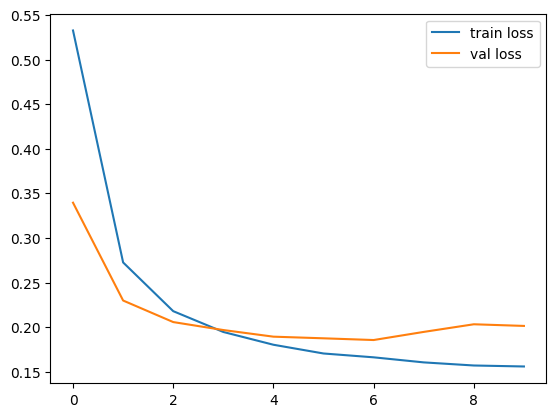

In [ ]:
# plot learning curve
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

# Evaluation

## Load model

### Encoder-only

In [15]:
# Encoder config
encoder = EncoderOnly(vocab_size=trainset.vocab_size,
                      d_model=200,
                      max_seq_length=1000,
                      nhead=4,
                      num_layers=2,
                      dim_feedforward=400,
                      dropout=0.3,
                      glove_embeddings=None,
                      ).to(device)

encoder.load_state_dict(torch.load('models/encoder.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [16]:
def classify(transformer, pad_src_seqs, src_mask):
    """Translate sequences from the source language to the target language using the trained model.

    Args:
    transformer: Trained transformer.
    pad_src_seqs of shape (max_src_seq_length, batch_size): Padded source sequences.
    src_seq_lengths: List of source sequence lengths.

    Returns:
    out_seqs of shape (batch_size, 1): LongTensor of word indices of the output sequences.
    """
    # YOUR CODE HERE
    with torch.no_grad():
        transformer.eval()
        pad_src_seqs, src_mask = pad_src_seqs.to(device), src_mask.to(device)
        outputs = transformer(pad_src_seqs, src_mask)
        out_seqs = outputs > 0.5
        return out_seqs

In [17]:
def test_translate_shapes(transformer):
    pad_src_seqs = torch.tensor([
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0]
    ])
    src_mask = torch.tensor([
        [False, False],
        [False, False],
        [False, True],
        [False, True],
    ])

    out_seqs = classify(transformer, pad_src_seqs, src_mask)
    assert out_seqs.shape == torch.Size([2, 1]), f"Wrong out_seqs.shape: {out_seqs.shape}"
    print('Success')

test_translate_shapes(encoder)

# Translate a few sentences from the training set
print('Classify training data:')
print('-----------------------------')
pad_src_seqs, src_mask, pad_tgt_seqs, ids = next(iter(valloader))
out_seqs = classify(encoder, pad_src_seqs, src_mask)

for i in range(5):
    print('SRC:', seq_to_tokens(pad_src_seqs[:,i], trainset.vocab))
    print('TGT:', pad_tgt_seqs[i].item())
    print('OUT:', out_seqs[i].item())
    print('')

Success
Classify training data:
-----------------------------
SRC: ['<CLS>', 'he', 'be', 'old', 'and', 'be', 'carry', 'a', 'small', 'bucket', '.', '<EOS>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>', '<UNK>'

In [18]:
def test_accuracy(lstm, dataloader=valloader):
    correct = 0
    total = 0
    for i, (src_seqs, src_mask, tgt_labels, ids) in enumerate(dataloader):
        out_seqs = classify(lstm, src_seqs, src_mask)
        correct += (out_seqs.squeeze().cpu().long() == tgt_labels).sum().item()
        total += tgt_labels.shape[0]
    accuracy = correct / total
    return accuracy

def test_f1_score(lstm, dataloader=valloader):
    y_true = []
    y_pred = []
    for i, (src_seqs, src_seq_lengths, tgt_labels, ids) in enumerate(dataloader):
        out_seqs = classify(lstm, src_seqs, src_seq_lengths)
        y_true.extend(tgt_labels.cpu().numpy())
        y_pred.extend(out_seqs.squeeze().cpu().numpy())
    return f1_score(y_true, y_pred)

In [ ]:
print(test_f1_score(encoder, valloader))

0.9053487798866157


In [19]:
# load testset
testset = torch.load('datasets/transformer/testset.pth')
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=False, collate_fn=collate, pin_memory=True)

In [20]:
# do inference on test set and save the results into csv file
def test_inference(lstm, output_filename='submission.csv', testset=testset):
    testloader = DataLoader(dataset=testset, batch_size=32, shuffle=False, collate_fn=collate, pin_memory=True)
    out = []
    indices = []
    for i, (src_seqs, src_mask, tgt_labels, ids) in enumerate(testloader):
        out_seqs = classify(lstm, src_seqs, src_mask)
        try:
            out.extend(out_seqs.squeeze().cpu().numpy())
        except:
            out.append(out_seqs.squeeze().cpu().numpy())
        indices.extend(ids)
    df = pd.DataFrame({'id': indices, 'label': out})
    # convert label to int
    df['label'] = df['label'].astype(int)
    # sort by id
    df = df.sort_values(by='id')
    df.to_csv(output_filename, index=False)
    return df

test_inference(encoder, output_filename='dev_inference.csv', testset=valset)
# test_inference(encoder, output_filename='submission.csv', testset=testset)

,id,label
0,0,0
1,1,0
2,2,0
3,3,1
4,4,0
...,...,...
10995,10995,0
10996,10996,0
10997,10997,1
10998,10998,1


In [21]:
# import precision_score, recall_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score
# Compute Precision, Recall, and F1 Score of the imported predicted csv and the validation df
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return precision, recall, f1

# Load the predicted csv
y_pred = pd.read_csv('dev_inference.csv', index_col=0)
y_pred = y_pred['label'].tolist()

# Load the validation df
y_true = pd.read_csv('dev_2024.csv', quoting=3)
y_true = y_true['label'].tolist()

# Compute the metrics
precision, recall, f1 = compute_metrics(y_true, y_pred)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')

Precision: 0.9241487453212553
Recall: 0.9283493946294765
F1: 0.9261658636247359
